# Online PCA (And other tricks)
So this notebook was my exploration of the technique of performing a search over the space of othogonal matrices as described in:

Brockett, R. W. (1991). Dynamical systems that sort lists, diagonalize matrices, and solve linear programming problems. Linear Algebra and its applications, 146, 79-91.

This can be used to rotate in the feature space to produce an alignment of the maximum eigenvectors of a covariance matrix in an online manner. Hence the title. (You can also sort numbers with a continous dynamical system which is also cool)

I created such an online PCA module in the COPCA.py file

In [88]:
import numpy as np
from numpy.random import *
from numpy import matmul as mm
import matplotlib.pyplot as plt
import scipy as sp

import torch
from multimodal import *

np.set_printoptions(suppress=True)


In [89]:
def LieBracket(A,B):
    return np.matmul(A,B)-np.matmul(B,A)

def Grad(H,N):
    return LieBracket(H, LieBracket(H,N))

def ThetaGrad(T, Q, N):
    return  -T@N@T.T@Q@T + Q@T@N

def ThetaGrad2(T, Q, N):
    C = N@T.T@Q@T
    return -T@(C-C.T)

def haar_measure(n):
    z = (randn(n,n))/sqrt(2.0)
    q,r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d/np.abs(d)
    q = np.multiply(q,ph)
    return q

def RandomSON(n):
    M = randn(n,n)
    Q,R = np.linalg.qr(M)
#     Q = Q/np.sum(Q**2, 1, keepdims=True)
    return Q
    
    

In [70]:
M = RandomSON(5)
print (M)
print (np.matmul(M.T, M))
print (np.linalg.det(M))
E,V = np.linalg.eig(M)
print (E)

for i in range(10000):
    M = RandomSON(5)
    if (np.linalg.det(M) < 0):
        print ("WHOA")
# print (V)

[[-0.14105648  0.21161876 -0.21273187  0.58507399 -0.74010415]
 [ 0.15864404 -0.22682987  0.09329774 -0.68719626 -0.66515947]
 [ 0.85677118 -0.39429768 -0.02452943  0.33139356 -0.00700707]
 [ 0.22381056  0.31846923 -0.87795177 -0.26272785  0.09306424]
 [-0.41326397 -0.80428379 -0.41789913  0.08125343  0.03314636]]
[[ 1. -0.  0. -0.  0.]
 [-0.  1.  0. -0. -0.]
 [ 0.  0.  1.  0. -0.]
 [-0. -0.  0.  1. -0.]
 [ 0. -0. -0. -0.  1.]]
0.9999999999999999
[ 1.        +0.j          0.14229487+0.98982431j  0.14229487-0.98982431j
 -0.9532935 +0.30204554j -0.9532935 -0.30204554j]


[4.46781802 0.20138887 1.85625824 1.57317997 3.2494048  0.14919449
 3.32915188 3.75860158 4.28247441 1.97237984]
[0.14919449 0.20138887 1.57317997 1.85625824 1.97237984 3.2494048
 3.32915188 3.75860158 4.28247441 4.46781802]


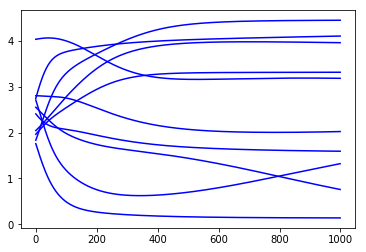

[0.14919449 0.20138887 1.57317997 1.85625824 1.97237984 3.2494048
 3.32915188 3.75860158 4.28247441 4.46781802]
[0.13726351 0.75799291 1.31991368 1.59207103 3.18274276 2.02112666
 3.31498449 3.95987699 4.10443055 4.44944951]


In [140]:
L = 5*np.random.rand(10)
S = np.sort(L)

print (L)
print (S)

# Initialize H and N
N = np.diag(range(1,11))
# H starts as the diagonal matrix of values you want sorted acted on by a
# matrix theta which is SO(n)
H = np.diag(L)
Q = RandomSON(len(L))
H = np.matmul(Q.T, np.matmul(H, Q))

steps = 1000
eta = 1e-3

diag = np.zeros((steps, len(L)))

for i in range(steps):
    diag[i,:] = np.diag(H)
    delH = Grad(H, N)
    H += eta*delH
    
for i in range(len(L)):
    plt.plot(diag[:,i], '-b')
# plt.ylim(-10,10)
plt.show()

print (S)
print (diag[-1,:])

In [139]:
M = RandomSON(5)

In [73]:
class Adam():
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        
        self.m = np.zeros_like(param)
        self.v = np.zeros_like(param)
        self.t = 0
        
        self.eps = eps
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        
    def __call__(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1
        
        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)
        
        return m_hat / (np.sqrt(v_hat) + self.eps)

In [127]:
D = 5

Q = np.zeros((D,D))
for i in range(20):
    x = randn(1,D)
    Q += x.T@x

E,V = np.linalg.eig(Q)    

print (Q)
T = RandomSON(D)
print ()
print (T)
N = np.diag(range(1,D+1))
print ()
print (N)

delT = ThetaGrad(T,Q,N)
delT2 = ThetaGrad2(T,Q,N)
print ()
print (np.allclose(delT, delT2))

steps = 10000
eta = 1e-4

for i in range(steps):
    delT = ThetaGrad2(T,Q,N)
    T += eta*delT

print ()
print (T)

L = T.T@Q@T

print (L)
print ()
print (np.diag(L))
print (E)





[[21.00085597  8.53132613  3.62553652  1.47553519 -2.24384595]
 [ 8.53132613 36.36994365  1.27939639 11.94387103  1.70751881]
 [ 3.62553652  1.27939639 29.85552922  0.47829621  4.93217528]
 [ 1.47553519 11.94387103  0.47829621 10.39637535  3.29309545]
 [-2.24384595  1.70751881  4.93217528  3.29309545 14.66702439]]

[[-0.22220878  0.85528757  0.04710673 -0.38785256 -0.25779406]
 [-0.3096027  -0.47818976 -0.14993092 -0.79340027 -0.15335399]
 [-0.15794843 -0.00466177 -0.79790626  0.3103263  -0.4920099 ]
 [ 0.85273078 -0.0259305   0.02845381 -0.23238839 -0.46622295]
 [ 0.32042461  0.19779687 -0.58123803 -0.26415832  0.67125792]]

[[1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 3 0 0]
 [0 0 0 4 0]
 [0 0 0 0 5]]

True

[[ 0.05644579  0.49472235  0.79172961  0.07221918 -0.34821188]
 [-0.34625578 -0.25492135 -0.16874216 -0.2427222  -0.85356046]
 [ 0.04262058 -0.2870943   0.00471903  0.93670329 -0.19926027]
 [ 0.90111314  0.10154137 -0.26264016 -0.07734154 -0.32156055]
 [-0.25368892  0.77364047 -0.52663013  0.

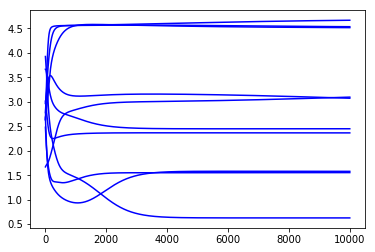

[0.63839997 1.5489664  1.59376325 2.37010746 2.45670942 2.98931415
 3.1784957  4.46897679 4.5358569  4.6788564 ]
[0.62660862 1.57847046 1.55297423 2.3647134  2.44904884 3.07328478
 3.09575519 4.51605631 4.53531969 4.66721493]


In [105]:
# Initialize H and N
N = np.diag(range(1,11))
# H starts as the diagonal matrix of values you want sorted acted on by a
# matrix theta which is SO(n)
H = np.diag(L)
Q = RandomSON(len(L))
H = np.matmul(Q.T, np.matmul(H, Q))

steps = 10000
eta = 1e-3

diag = np.zeros((steps, len(L)))

for i in range(steps):
    diag[i,:] = np.diag(H)
    delH = Grad(H, N)
    H += eta*delH
    
for i in range(len(L)):
    plt.plot(diag[:,i], '-b')
# plt.ylim(-10,10)
plt.show()

print (S)
print (diag[-1,:])

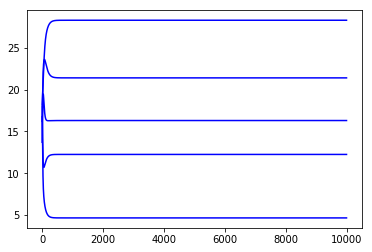

[ 4.98885753 27.86935012 12.25388782 16.37148991 21.38817742]
[ 4.6497666  12.24167159 16.29578437 21.39623991 28.28830034]


In [108]:
# Initialize H and N
D = 5

N = np.diag(range(1,D+1))
# H starts as the diagonal matrix of values you want sorted acted on by a
# matrix theta which is SO(n)
H = np.zeros((5,5))
for i in range(20):
    x = randn(1,D)
    H += x.T@x
E,V = np.linalg.eig(H)

steps = 10000
eta = 1e-3

diag = np.zeros((steps, D))

for i in range(steps):
    diag[i,:] = np.diag(H)
    delH = Grad(H, N)
    H += eta*delH
    
for i in range(D):
    plt.plot(diag[:,i], '-b')
# plt.ylim(-10,10)
plt.show()

print (E)
print (diag[-1,:])

In [109]:
M = RandomSON(5)
D = np.diag(randn(5))

print (M.T@D@M)

[[-0.63808637  0.42951985  0.17969005 -0.20200037  0.04751013]
 [ 0.42951985  0.44070475 -0.3030683  -0.54912934 -0.12484367]
 [ 0.17969005 -0.3030683   0.45087892  0.47644084  0.59940037]
 [-0.20200037 -0.54912934  0.47644084 -0.78258183 -0.18629244]
 [ 0.04751013 -0.12484367  0.59940037 -0.18629244 -0.72151   ]]


In [147]:
D = 5
C = 3
M = 20

Q = np.zeros((D,D))
X = []
for i in range(M):
    x = randn(1,D)
    X.append(x)
    Q += x.T@x/M

E,V = np.linalg.eig(Q)    

T = RandomSON(D)[:,:C]
N = np.diag(range(1,C+1))

steps = 1000000
eta = 5e-5

for i in range(steps):
    xs = X[i%M]
    delT = ThetaGrad2(T,xs,N)
    T += eta*delT

L = T.T@Q@T

print (L)
print ()
print (np.diag(L))
print (E)



[[ 0.35691225  0.00004163 -0.00007698]
 [ 0.00004163  0.72345265  0.00005438]
 [-0.00007698  0.00005438  1.7285864 ]]

[0.35691225 0.72345265 1.7285864 ]
[2.05823659 0.23835424 1.015295   0.55418231 0.65892683]


In [157]:
def ThetaGrad2(T, x, N):
    print (T.shape, x.shape, N.shape)
    xt = x@T
    print (xt.shape)
    C = N@xt.T@xt
    print (C.shape)
    return -T@(C-C.T)

inputs = 5
outputs = 3

T = RandomSON(inputs)[:,:outputs]
N = np.diag(range(1,outputs+1))

print (T)
print (N)

x = randn(1,5)
print (x)

print(ThetaGrad2(T,x,N))

x = torch.Tensor(x)
T = torch.Tensor(T)
N = torch.Tensor(N)

xt = torch.einsum('bi,ij->bj', [x, T])
X = torch.einsum('bk,bl->bkl',[xt, xt]).mean(0)
C = torch.einsum('ik,kl->il', [N,X])
C2 = torch.einsum('ij,bk,bl->il',[N,xt,xt])
Tgrad = -T@(C-C.transpose(0,1))
Tgrad2 = -T@(C2-C2.transpose(0,1))

print (Tgrad)
print (Tgrad2)

# def ThetaGrad2(T, Q, N):
#     C = N@T.T@Q@T
#     return -T@(C-C.T)

[[-0.17720847  0.04653153 -0.71272901]
 [ 0.81397218 -0.53335286 -0.20442954]
 [ 0.05363835  0.10230408 -0.48402651]
 [ 0.34710074  0.29002758  0.42413615]
 [ 0.42742303  0.78663042 -0.18987571]]
[[1 0 0]
 [0 2 0]
 [0 0 3]]
[[-0.22802054  0.53550527 -0.03213989  1.88711985  2.27984014]]
(5, 3) (1, 5) (3, 3)
(1, 3)
(3, 3)
[[ 1.10815125 -0.12660882 -0.28378962]
 [ 2.66579684  3.67780637  1.01901089]
 [ 0.4489081   0.66123818  0.18950625]
 [-2.02397344  1.11315895  0.89517454]
 [-3.02994127  2.00470975  1.48465017]]
tensor([[ 1.1082, -0.1266, -0.2838],
        [ 2.6658,  3.6778,  1.0190],
        [ 0.4489,  0.6612,  0.1895],
        [-2.0240,  1.1132,  0.8952],
        [-3.0299,  2.0047,  1.4847]])
tensor([[ 18.7249,  15.3879,  -3.6510],
        [ 10.7980,  12.9988,   9.0807],
        [ 12.0145,  12.1774,   3.9052],
        [-14.2970,  -6.7583,  16.3216],
        [ -2.6976,   8.8113,  30.4314]])


In [158]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OPCA(nn.Module):
    def __init__(self, inputs, outputs, eta=1e-3, gamma=0):
        
        # OPCA
        self.register_buffer('T', torch.tensor(RandomSON(inputs)[:,:outputs]))
        self.register_buffer('N', torch.diag(torch.arange(outputs+1,0,-1)))
        self.register_buffer('eta', torch.tensor(eta))
        
        # Centering
        self.register_buffer('mu', torch.zeros(inputs))
        self.register_buffer('gamma', torch.tensor(gamma))
        
    def forward(self, x):
        
        # Centering
        x = x-self.mu
        
        # EMA
        self.mu *= (1-self.gamma)
        self.mu += self.gamma*(x.mean(0))
        
        # Batched OPCA
        xt = torch.einsum('bi,ij->bj', [x, self.T])
        X = torch.einsum('bk,bl->bkl',[xt, xt]).mean(0)
        C = torch.einsum('ik,kl->il', [self.N, X])
        Tgrad = -T@(C-C.transpose(0,1))
        
        self.T += self.eta*Tgrad
        
        return xt
        
        

In [142]:
print (torch.arange(5,0,-1))

tensor([5, 4, 3, 2, 1])
